# Training models

In [1]:
from data_preprocessing import full_pipeline, splits_to_dataloaders
from random_forest import run_experiment as run_random_forest_experiment
from xg_boost import run_experiment as run_xgboost_experiment
from nn import run_experiment as run_nn_experiment
from utils import write_submissions
import os

In [9]:
data_dir = "./data/"
train_x_path = os.path.join(data_dir, "x_train_T9QMMVq.csv")
train_y_path = os.path.join(data_dir, "y_train_R0MqWmu.csv")
test_x_path = os.path.join(data_dir, "x_test_9F13O5s.csv")

x_train, y_train, x_val, y_val = full_pipeline(train_x_path, train_y_path, val_proportion=0.1, reduce_features=False)
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X val shape:", x_val.shape)
print("Y val shape:", y_val.shape)

X train shape: (182639, 14)
Y train shape: (182639, 23)
X val shape: (20294, 14)
Y val shape: (20294, 23)


In [6]:
print("Basic Random Forest")
rf_model = run_random_forest_experiment(x_train, y_train, x_val, y_val)

Basic Random Forest
Validation Weighted RMSE: 0.1182


In [ ]:
print("XGBoost")
xgb_model = run_xgboost_experiment(x_train, y_train, x_val, y_val)

/Users/kiki/.pyenv/versions/3.12.2/envs/idgaz/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Neural Network
Number of trainable parameters: 41111


Epoch 100/100 - Train Loss: 0.0529, Val Loss: 0.0302, LR: 0.000031: 100%|██████████| 100/100 [12:37<00:00,  7.57s/it]


Validation Weighted RMSE: 0.0302


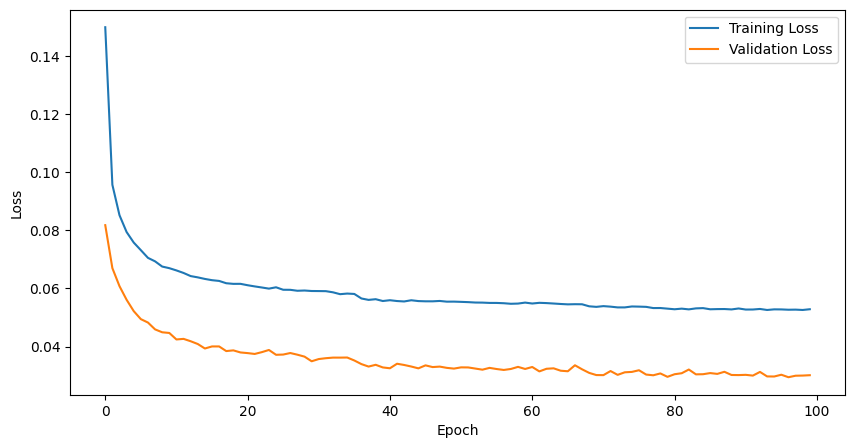

In [10]:
print("Neural Network")
params = {
    "model_params": {
        "hidden_dim": 512,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.0,
    },
    "training_param": {
        "n_epochs": 100,
        "lr": 0.01,
        "weight_decay": 1e-5,
        "batch_size": 128,
    },
}
try:
    nn_model = run_nn_experiment(x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True)
except KeyboardInterrupt:
    print("Training interrupted.")

In [11]:
write_submissions(nn_model, test_x_path, "submissions_nn_v1.csv")